<a href="https://colab.research.google.com/github/MicahSee/Novel-Time-Series-Models/blob/main/Novel_Times_Series_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.3 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, TimesNet

from neuralforecast.losses.numpy import mae, mse

In [ ]:
plt.rcParams["figure.figsize"] = (9,6)

## Read data

In [ ]:
import requests

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&outputsize=full&datatype=csv&apikey=ZN0OVWTE2EQWLSVI'

r = requests.get(url)
with open('IBM_daily.csv', 'wb') as f:
    f.write(r.content)

In [ ]:
df = pd.read_csv('IBM_daily.csv')

In [ ]:
stock_df = df[::-1].set_index(df.index)
stock_df = stock_df.rename(columns={'timestamp': 'ds', 'close': 'y'})
stock_df = stock_df[['ds', 'y', 'volume']]
stock_df['unique_id'] = 'OT'
# stock_df['ds'] = pd.to_datetime(stock_df['ds'], format='%Y-%m-%d')

In [ ]:
stock_df

,ds,y,volume,unique_id
0,1999-11-01,96.75,9551800,OT
1,1999-11-02,94.81,11105400,OT
2,1999-11-03,94.37,10369100,OT
3,1999-11-04,91.56,16697600,OT
4,1999-11-05,90.25,13737600,OT
...,...,...,...,...
6084,2024-01-08,161.14,3321698,OT
6085,2024-01-09,160.08,2617186,OT
6086,2024-01-10,161.23,2967852,OT
6087,2024-01-11,162.16,3778395,OT


Note: forgot to account for the fact that the stock market isn't open every day

In [ ]:
import datetime as datetime

def get_weekday(date_str):
    return datetime.datetime.strptime(date_str, '%Y-%m-%d').weekday()

stock_df['day'] = stock_df['ds'].apply(lambda x: get_weekday(x))

In [ ]:
stock_df.head(20)

,ds,y,volume,unique_id,day
0,1999-11-01,96.75,9551800,OT,0
1,1999-11-02,94.81,11105400,OT,1
2,1999-11-03,94.37,10369100,OT,2
3,1999-11-04,91.56,16697600,OT,3
4,1999-11-05,90.25,13737600,OT,4
5,1999-11-08,93.94,8522300,OT,0
6,1999-11-09,93.62,9551200,OT,1
7,1999-11-10,97.00,8680300,OT,2
8,1999-11-11,95.00,7147500,OT,3
9,1999-11-12,95.87,9668400,OT,4


In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.3 MB/s eta 0:00:00


In [ ]:
# Perform binary encoding for day of the week
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['day'])
stock_df_encoded = encoder.fit_transform(stock_df)

In [ ]:
stock_df_encoded.head(20)

,ds,y,volume,unique_id,day_0,day_1,day_2
0,1999-11-01,96.75,9551800,OT,0,0,1
1,1999-11-02,94.81,11105400,OT,0,1,0
2,1999-11-03,94.37,10369100,OT,0,1,1
3,1999-11-04,91.56,16697600,OT,1,0,0
4,1999-11-05,90.25,13737600,OT,1,0,1
5,1999-11-08,93.94,8522300,OT,0,0,1
6,1999-11-09,93.62,9551200,OT,0,1,0
7,1999-11-10,97.00,8680300,OT,0,1,1
8,1999-11-11,95.00,7147500,OT,1,0,0
9,1999-11-12,95.87,9668400,OT,1,0,1


In [ ]:
fig, ax = plt.subplots()

ax.plot(stock_df['ds'], stock_df['volume'])
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title('IBM Stock Price')

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
stock_df_encoded['ds'] = np.arange(len(stock_df_encoded))

<Axes: xlabel='ds'>

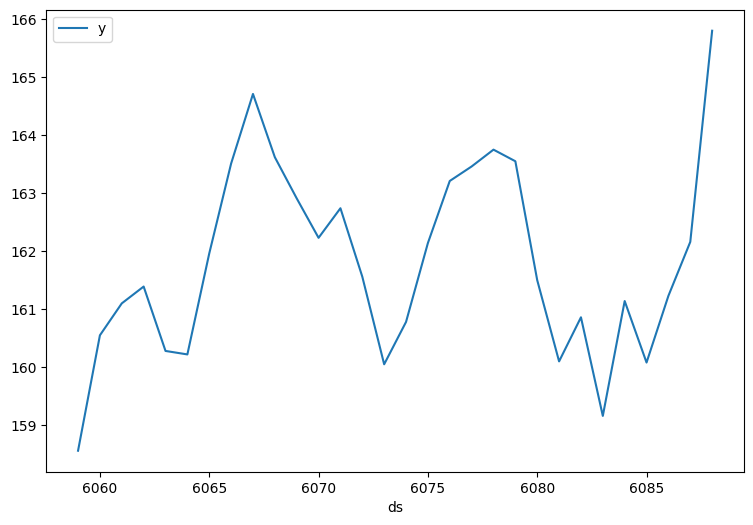

In [ ]:
futr_df = stock_df_encoded.iloc[-30:, :]
futr_df.plot(x='ds', y='y')

In [ ]:
futr_df

,ds,y,volume,unique_id,day_0,day_1,day_2
6059,6059,158.56,6740622,OT,1,0,0
6060,6060,160.55,4871860,OT,1,0,1
6061,6061,161.10,5779017,OT,0,0,1
6062,6062,161.39,4556668,OT,0,1,0
6063,6063,160.28,3356432,OT,0,1,1
6064,6064,160.22,3665498,OT,1,0,0
6065,6065,161.96,4561342,OT,1,0,1
6066,6066,163.51,6077207,OT,0,0,1
6067,6067,164.71,5292290,OT,0,1,0
6068,6068,163.62,4989141,OT,0,1,1


In [ ]:
futr_df = futr_df.drop(columns=['y', 'volume'])

In [ ]:
futr_df

,ds,unique_id,day_0,day_1,day_2
6059,6059,OT,1,0,0
6060,6060,OT,1,0,1
6061,6061,OT,0,0,1
6062,6062,OT,0,1,0
6063,6063,OT,0,1,1
6064,6064,OT,1,0,0
6065,6065,OT,1,0,1
6066,6066,OT,0,0,1
6067,6067,OT,0,1,0
6068,6068,OT,0,1,1


## Model

In [ ]:
from neuralforecast.auto import AutoTimesNet

In [ ]:
from neuralforecast.models import DeepAR

In [ ]:
horizon = 30

models = [NHITS(h=horizon,
               input_size=2*horizon,
               max_steps=200,
               scaler_type='robust',
               futr_exog_list=['day_0', 'day_1', 'day_2'],
               hist_exog_list=['volume']),
        #  NBEATS(h=horizon,
        #        input_size=2*horizon,
        #        max_steps=50),
        #  TimesNet(h=horizon,
        #          input_size=2*horizon,
        #          max_steps=50),
        #  DeepAR(h=horizon,
        #        input_size=2*horizon,
        #        max_steps=50)
          ]

# models = [NHITS(h=horizon,
#                input_size=5*horizon,
#                max_steps=200,
#                scaler_type='robust',
#                hist_exog_list=['volume'])]

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
nf = NeuralForecast(models=models, freq='D')

In [ ]:
# Y_hat_df = nf.cross_validation(df=stock_df, step_size=horizon, n_windows=2)

In [ ]:
train_df = stock_df_encoded.iloc[:-30, :]
train_df

,ds,y,volume,unique_id,day_0,day_1,day_2
0,0,96.75,9551800,OT,0,0,1
1,1,94.81,11105400,OT,0,1,0
2,2,94.37,10369100,OT,0,1,1
3,3,91.56,16697600,OT,1,0,0
4,4,90.25,13737600,OT,1,0,1
...,...,...,...,...,...,...,...
6054,6054,155.13,3045091,OT,0,1,1
6055,6055,155.18,1799161,OT,1,0,1
6056,6056,155.57,4053093,OT,0,0,1
6057,6057,155.65,2666182,OT,0,1,0


In [ ]:
nf.fit(train_df)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,index,unique_id,ds,cutoff,NHITS,NBEATS,DeepAR,DeepAR-median,DeepAR-lo-90,DeepAR-lo-80,DeepAR-hi-80,DeepAR-hi-90,y,volume
0,0,OT,5999,5998,147.187363,148.490234,-2.059574,2.060390,-21.604797,-12.980835,17.120810,22.788017,148.06,2932203
1,1,OT,6000,5998,147.141891,148.463867,2.852282,3.594767,-22.891094,-13.307110,15.331741,30.793121,147.52,3333040
2,2,OT,6001,5998,146.740891,148.516479,5.337859,4.336296,-9.840151,-6.662360,17.963545,34.485897,147.68,3722927
3,3,OT,6002,5998,146.882156,148.407181,4.811702,3.920193,-12.727846,-8.900832,12.881578,16.932343,148.38,3273720
4,4,OT,6003,5998,146.701797,148.214752,1.630167,0.604986,-12.520552,-9.395149,14.413201,21.030886,146.30,4457695


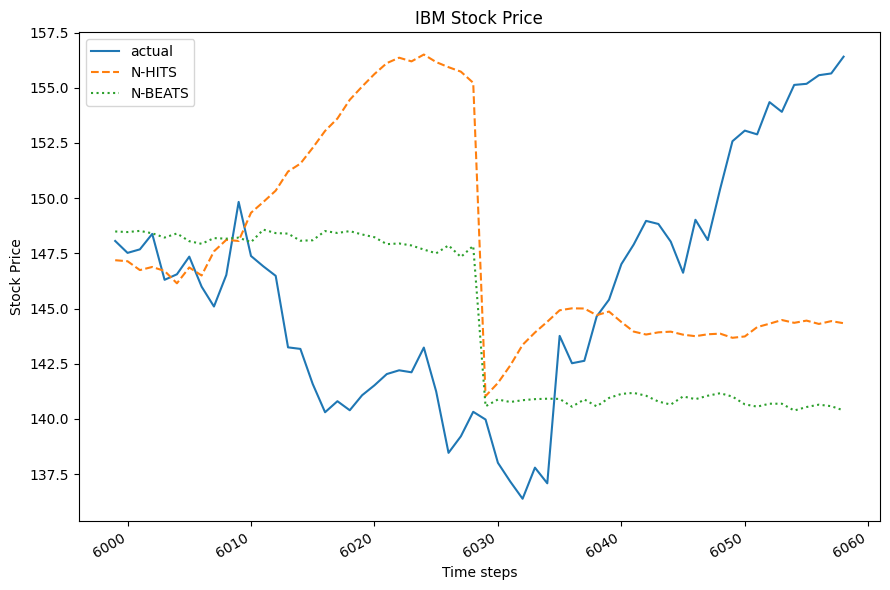

In [ ]:
fig, ax = plt.subplots()

preds_df = Y_hat_df.set_index('ds')

ax.plot(preds_df['y'], label='actual')
ax.plot(preds_df['NHITS'], label='N-HITS', ls='--')
ax.plot(preds_df['NBEATS'], label='N-BEATS', ls=':')
# ax.plot(preds_df['TimesNet'], label='TimesNet', ls='-.')

ax.legend(loc='best')
ax.set_xlabel('Time steps')
ax.set_ylabel('Stock Price')
ax.set_title('IBM Stock Price')

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
futr_df = futr_df.set_index(np.arange(len(futr_df)))
futr_df

,ds,unique_id,day_0,day_1,day_2
0,6059,OT,1,0,0
1,6060,OT,1,0,1
2,6061,OT,0,0,1
3,6062,OT,0,1,0
4,6063,OT,0,1,1
5,6064,OT,1,0,0
6,6065,OT,1,0,1
7,6066,OT,0,0,1
8,6067,OT,0,1,0
9,6068,OT,0,1,1


In [ ]:
preds = nf.predict(futr_df=futr_df)

             ds
unique_id      
OT         6059
OT         6060
OT         6061
OT         6062
OT         6063
OT         6064
OT         6065
OT         6066
OT         6067
OT         6068
OT         6069
OT         6070
OT         6071
OT         6072
OT         6073
OT         6074
OT         6075
OT         6076
OT         6077
OT         6078
OT         6079
OT         6080
OT         6081
OT         6082
OT         6083
OT         6084
OT         6085
OT         6086
OT         6087
OT         6088


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
preds

,ds,NHITS
unique_id,,
OT,6059,157.289185
OT,6060,157.890244
OT,6061,158.688354
OT,6062,159.360687
OT,6063,159.961212
OT,6064,160.910095
OT,6065,161.347458
OT,6066,161.675781
OT,6067,161.852722


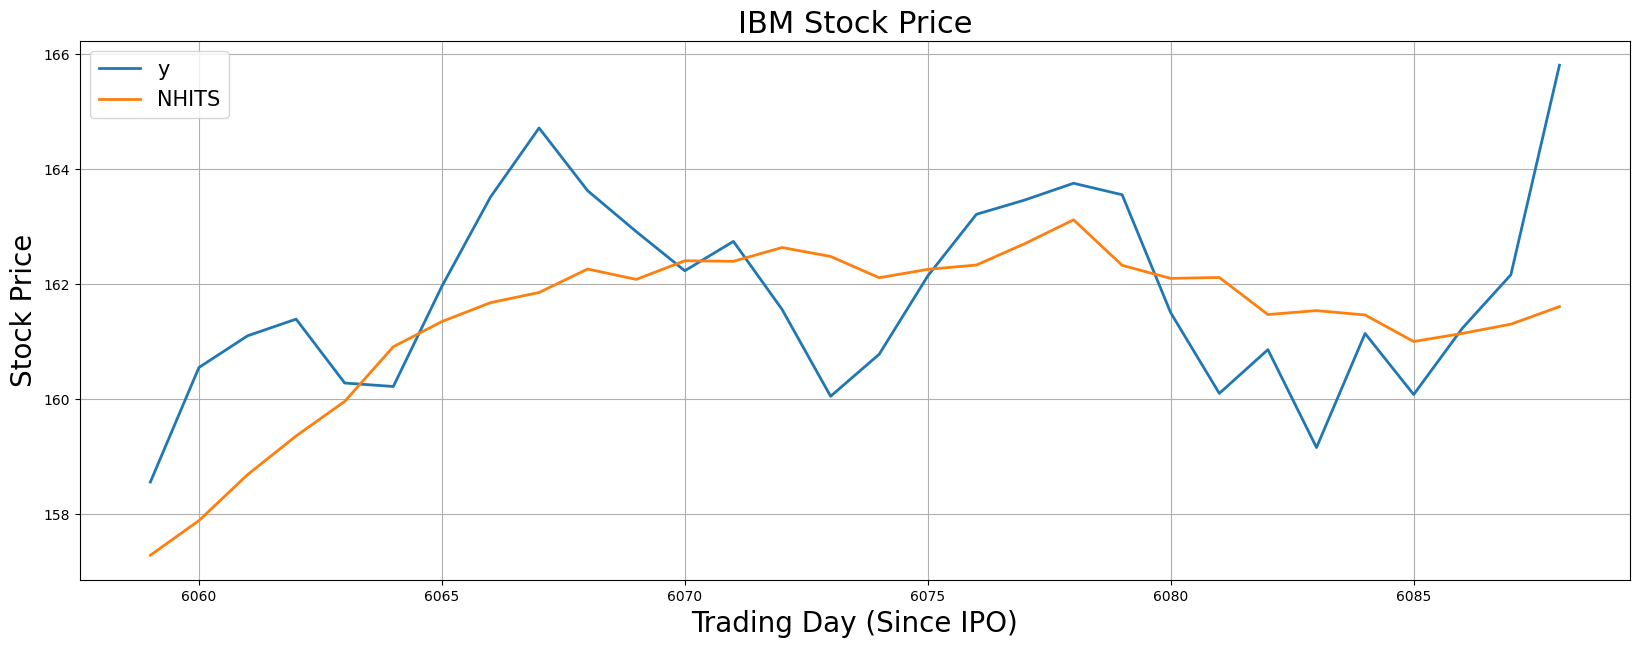

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
actual = stock_df_encoded.iloc[-30:, :].set_index('ds')
actual[['y']].plot(ax=ax, linewidth=2)
pred_df = preds.set_index('ds')
pred_df[['NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('IBM Stock Price', fontsize=22)
ax.set_ylabel('Stock Price', fontsize=20)
ax.set_xlabel('Trading Day (Since IPO)', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [ ]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y'])],
       'TimesNet': [mae(preds_df['TimesNet'], preds_df['y']), mse(preds_df['TimesNet'], preds_df['y'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

NameError: name 'preds_df' is not defined